# PIV to HDF5
The coordinate system of a PIV recording has axis names `x`, `y` and `z`. The illuminated plane is the `xy`-plane. Thus, ich plane has a constant `z`-coordinate. As a PIV recording consists of multiple images over time, this information is stored in the time vector `t`.<br>

Definition of a `snapshot`, a `plane` and a `case` is exactly:
- A `snapshot` represents an instantaneous PIV result, thus results from a single double-image recording.
- A `plane` represents a series of recordings (snaphsots) which are in one physical (xy)-plane.
- Multiple planes together are called a `case` or simply multi-plane.

<img src="introduction_piv_setup.png" alt="Drawing" style="height: 5cm;"/>

In [1]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox import x2hdf

## Configuration
The conversion of PIV data into a single HDF file is controlled via a configuration dicitonary. It defines how data is treated during the conversion process (e.g. how to handle masked data) but also if post-processing steps should be run, like computing the time averages or running means, for instance.

In [2]:
x2hdf.piv.config

{'interpolation': False,
 'apply_mask': True,
 'masking': 'slack',
 'time_unit': 's',
 'z_source': 'coord_min',
 'datetime_str': '%Y-%m-%dT%H:%M:%SZ%z',
 'attrs_unit_name': 'units',
 'compression': 'gzip',
 'compression_opts': 5,
 'take_min_nt': True,
 'standardized_name_table': 'piv-v1',
 'timeAverages': {'compute': False, 'use_nc': False},
 'post': {'compute': False,
  'grpname': 'post',
  'grpdesc': 'Post processing data',
  'running_mean': {'compute': False,
   'grpname': 'running_mean',
   'grpdesc': 'Running mean',
   'dataset_names': ['u', 'v']},
  'running_std': {'compute': False,
   'grpname': 'running_std',
   'grpdesc': 'Running standard deviation',
   'dataset_names': ['u', 'v']},
  'velocity_abs_ds_name': 'c',
  'compute_dwdz': False}}

## Snapshot to HDF
This simplest case is to convert a single PIV result into a single HDF file. Currently supported are 
 - netCDF4 files from PIVview (https://www.pivtec.com/pivview.html) and 
 - text files from OpenPIV (http://www.openpiv.net/)
 
The tutorial module provides a sample result file. We go thorugh converting the snapshot fo the openpiv example first:

### OpenPIV

In [3]:
# get the test file:
openpiv_txt_file = h5tbx.tutorial.OpenPIV.get_snapshot_txt_file()
openpiv_par_file = h5tbx.tutorial.OpenPIV.get_parameter_file()

# init a openpiv-file instance:
openpiv_file = h5tbx.x2hdf.piv.openpiv.OpenPIVFile(openpiv_txt_file)
openpiv_file

openpiv_snapshot = h5tbx.x2hdf.piv.PIVSnapshot(openpiv_file, recording_time=0.)

Now we can write the data to an HDF file:

In [4]:
mylayout = h5tbx.conventions.H5Layout(h5tbx.generate_temporary_filename())
print(mylayout.filename)

with mylayout.File(mode='w') as h5:
    print(h5.mode)
    h5.attrs['title'] = '__any'
    # dsx = h5.create_dataset('x', shape=(1,))  # shape does not matter here, but has to be passed
    # dsx.attrs['standard_name.alt:long_name'] = '__any'
    # dsy = h5.create_dataset('y', shape=(1,))  # shape does not matter here, but has to be passed
    # dsy.attrs['standard_name.alt:long_name'] = '__any'
    # h5.create_group('meta')
    # h5.create_group('meta/other')
mylayout.dump()

C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp199\tmp0
r+
> File: Group name: /.

a: title:                         __any



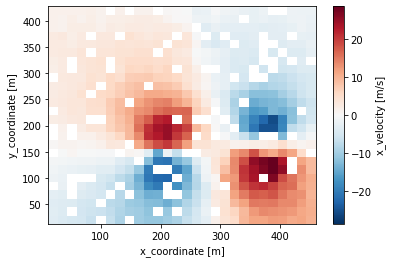

In [5]:
hdf_filename = openpiv_snapshot.to_hdf()
with h5tbx.H5PIV(hdf_filename) as h5:
    h5.dump(check=True)
    h5.u[:].plot()

In [6]:
pivview_nc_file = h5tbx.tutorial.PIVview.get_snapshot_nc_files()[0]


`PIVSnapshot` is the interface class to PIV data. It takes a `PIVFile` object. For PIVview such a object is already implemented (`PIVviewFile`). It can either be passed or the method `from_pivview()` can be called.

In [7]:
pivview_file = h5tbx.x2hdf.piv.pivview.PIVViewNcFile(pivview_nc_file, None)
pivview_file

In [8]:
snapshot_pivview = h5tbx.x2hdf.piv.PIVSnapshot(pivview_file, recording_time=0.)
# snapshot = h5tbx.x2hdf.PIVSnapshot.from_pivview(nc_file, 0.)

To actually convert the data the methd `to_hdf()` must be called:

In [9]:
hdf_filename = snapshot_pivview.to_hdf()

Let's have a look, which datasets have been written and what their shapes are. This is easily done with `H5PIV`

C:\Users\da4323\Documents\programming\GitHub\h5RDMtoolbox\h5rdmtoolbox\h5wrapper\h5file.py:1676: StandardizedNameTableWarning: Unable to write standard name table to file. It will be effective anyhow but if the file is reloaded later the choice is forgotten.
  warnings.warn(


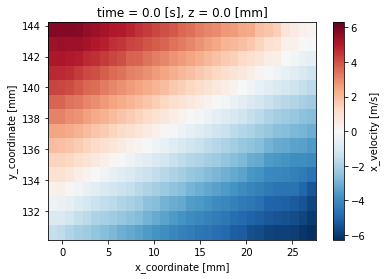

In [10]:
with h5tbx.H5PIV(hdf_filename, 'r') as h5piv:
    h5piv.u[:].plot()

## Plane to HDF

In [11]:
piv_folder = h5tbx.tutorial.PIVview.get_plane_directory()

In [12]:
plane = h5tbx.x2hdf.piv.PIVPlane.from_plane_folder(piv_folder, 5, h5tbx.x2hdf.piv.pivview.PIVViewNcFile)

In [13]:
hdf_filename = plane.to_hdf()

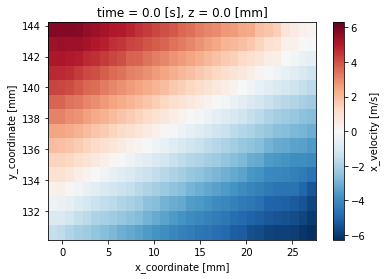

In [14]:
with h5tbx.H5PIV(hdf_filename, 'r') as h5piv:
    h5piv.dump()
    h5piv.u[0, :, :].plot()

## Multiple planes to HDF

In [15]:
plane_dirs = h5tbx.tutorial.PIVview.get_multiplane_directories()

In [16]:
plane_objs = [h5tbx.x2hdf.piv.PIVPlane.from_plane_folder(d, 5, h5tbx.x2hdf.piv.PIVViewNcFile) for d in plane_dirs]

In [17]:
mplane = h5tbx.x2hdf.piv.PIVMultiPlane(plane_objs)

In [18]:
hdf_filename = mplane.to_hdf()
hdf_filename

WindowsPath('C:/Users/da4323/AppData/Local/h5rdmtoolbox/h5rdmtoolbox/tmp/tmp199/mplane.hdf')

In [19]:
with h5tbx.H5PIV(hdf_filename, 'r') as h5piv:
    h5piv.dump()
    h5piv.check(silent=False)
    params = h5piv.get_parameters(0)
params

Attribute creation_time missing in group /
